# MNIST Tutorial for Beginners

Welcome to this comprehensive tutorial on building a simple linear classifier using PyTorch to recognize handwritten digits from the MNIST dataset. This tutorial is designed for individuals who have a basic understanding of Python and machine learning concepts but are new(er) to PyTorch and machine learning.

In this tutorial, you will learn how to:

1. Load and Preprocess Data: Understand how to use PyTorch's DataLoader to load and preprocess the MNIST dataset.
2. Define a Model: Implement a simple linear classifier (logistic regression) using PyTorch's neural network modules.
3. Train the Model: Write a training loop to train your model on the MNIST training dataset.
4. Evaluate the Model: Implement an evaluation function to assess the model's performance on the test dataset.
5. Understand Model Training: Gain insights into key concepts like model training, loss computation, and optimization.
6. Visualize Results: Learn how to visualize and interpret the results of your trained model.

### Loading Libraries and Setting Up

In [2]:
# Import important libraries
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

from timeit import default_timer as timer
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu' # For faster processing if you have a GPU

C:\Users\alexa\AppData\Local\Temp\ipykernel_7736\1332836739.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Some Helper functions

In [3]:
def accuracy_fn(y_true, y_pred):
    correct = (y_true == y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [4]:
def plot_loss_curves(results):
    
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

We first load in the data and inspect it.

In [5]:
train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)

In [6]:
# Basic information about the training and testing dataset
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of test samples: {len(test_dataset)}')
img_train, label_train = train_dataset[0]
img_test, label_test = test_dataset[0]
print(f'Shape of each image in the training dataset: {img_train.shape}')
print(f'Shape of each image in the testing dataset: {img_test.shape}')
print(f'Number of classes: {len(train_dataset.classes)}')
print(f'Classes: {train_dataset.classes}')

Number of training samples: 60000
Number of test samples: 10000
Shape of each image in the training dataset: torch.Size([1, 28, 28])
Shape of each image in the testing dataset: torch.Size([1, 28, 28])
Number of classes: 10
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


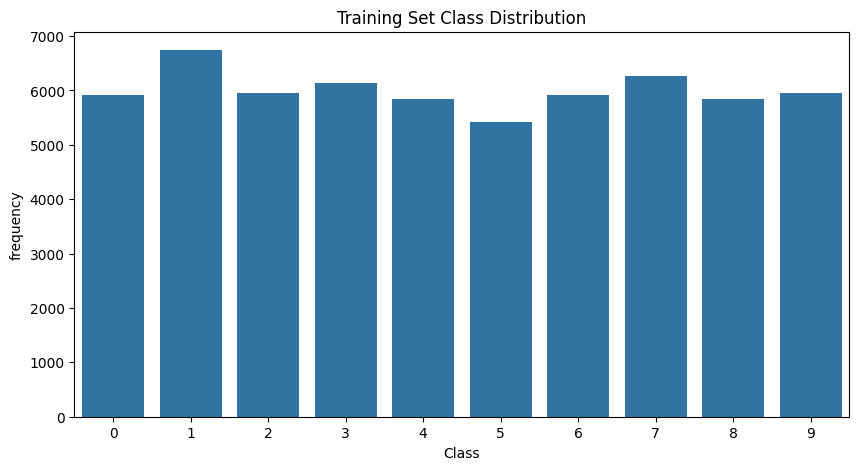

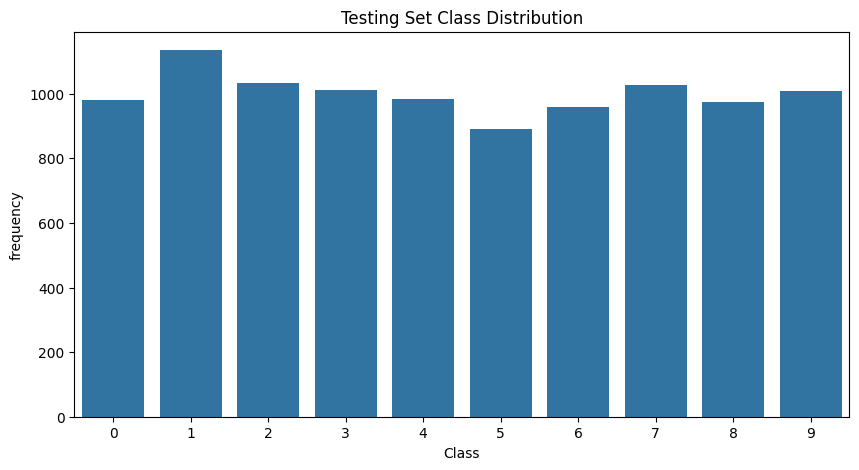

In [7]:
# Let's look at the class distribution. We want to identify whether the classes are balanced.
train_labels_df = pd.DataFrame(train_dataset.targets.numpy(), columns=['label'])
test_labels_df = pd.DataFrame(test_dataset.targets.numpy(), columns=['label'])

def plot_class_distribution(labels_df, title):
    plt.figure(figsize=(10, 5))
    sns.countplot(data=labels_df, x = 'label')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('frequency')
    plt.show()

plot_class_distribution(train_labels_df, 'Training Set Class Distribution')
plot_class_distribution(test_labels_df, 'Testing Set Class Distribution')


We see that the classes are slightly imbalanced. However, we can also observe that the imbalances are roughly similar in both datasets. This means that (at least for now) we do not have to account for the imbalances, as this imbalance also occurs in the test dataset - thus if the model does well on the imbalance in the training dataset, it hopefully also does on the testing dataset. Keep in mind that this is often not how it goes in real-life scenarios, i.e. the testing data is often not known/unavailable.

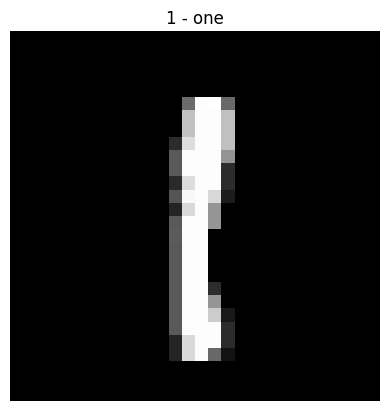

In [8]:
# We might want to set the seed to plot the same images
# torch.manual_seed(9)

class_names = train_dataset.classes

random_idx = torch.randint(low=0, high=len(train_dataset), size=[1]).item()
img, label = train_dataset[random_idx]
plt.imshow(img.squeeze(), cmap='gray') 
plt.title(class_names[label])
plt.axis('off')
plt.show()

From running the above code some times, we can see that most numbers look recognizable, but also that some are more difficult to guess than others. This is something we will have to take into account after our model has made predictions. It's always important to recognize that when our model makes mistakes, we *look* at these mistakes, because maybe we shouldn't call it a mistake:)

When we are working with images, we must not forget that each pixel is a feature. Therefore, as we would normally inspect our features (f.e. in tabular data) and their distribution, we can do the same for the pixels.

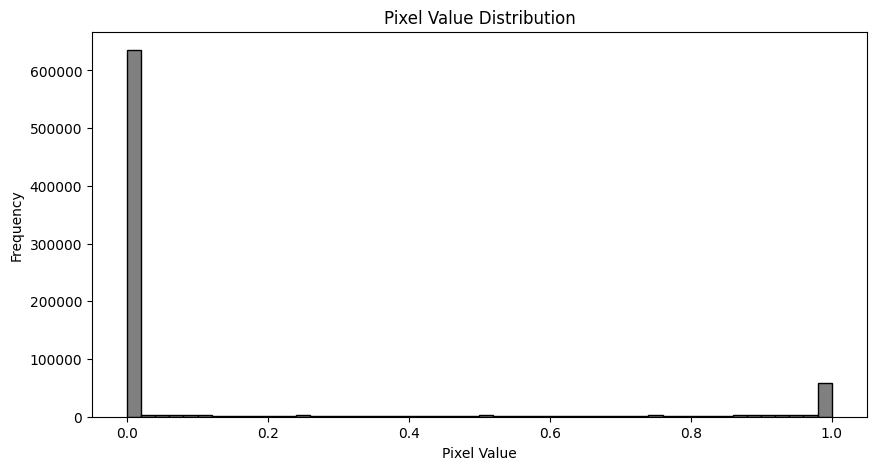

In [9]:
# Visualize the distribution of pixel values
def plot_pixel_distribution(dataset, num_samples=1000):
    pixels = np.concatenate([img.numpy().flatten() for img, _ in torch.utils.data.Subset(dataset, np.random.choice(len(dataset), num_samples, replace=False))])
    plt.figure(figsize=(10, 5))
    plt.hist(pixels, bins=50, color='gray', edgecolor='black')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Pixel Value Distribution')
    plt.show()

plot_pixel_distribution(train_dataset)


Now that we understand roughly what our data looks like, we will use DataLoaders to efficiently load the data into batches, which makes it easier to train neural networks. Moreover, we can decide whether we want to shuffle the data. We want to shuffle the data in the training dataloader to ensure diversity. There is also a lot of built-in support for data iteration, and just overall eases the job for us.

In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Baseline linear model
We build a baseline linear model for comparing with later models. However, in this tutorial, we will focus more on building a proper pipeline than focusing on complex models.

In [11]:
class BaseLineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=28*28, out_features=10) # nn.LazyLinear initializes the input_dimension based on the input.

    def forward(self, X):
        return self.linear(X.reshape(-1, 28*28))

We define a training and evaluating loop. This should be generalizable for other models as well.

In [12]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device=device):
    train_loss, train_acc = 0, 0
    model.to(device) # We set the model to our device for faster computation.
    model.train()
    
    for X, y in data_loader:
        X, y = X.to(device), y.to(device) # We set the data to our device for faster computation.
        y_pred = model(X) # We make the predictions

        loss = loss_fn(y_pred, y) 
        acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        train_loss += loss.item()
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

In [13]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device=device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device) # We set the data to our device for faster computation.

            y_pred = model(X) # We make the predictions

            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
            test_loss += loss.item()
            test_acc += acc

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
    
    return test_loss, test_acc

Now we combine the training and testing step

In [14]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10):
    
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        data_loader=test_dataloader,
                                        loss_fn=loss_fn)
        
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [15]:
EPOCHS = 10

baseline_model = BaseLineModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=baseline_model.parameters(), lr=0.01)

results = train(model=baseline_model, train_dataloader=train_loader, test_dataloader=test_loader, optimizer=optimizer, loss_fn=loss_fn)

  0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.97725 | Train accuracy: 80.49%


 10%|█         | 1/10 [00:18<02:44, 18.24s/it]

Test loss: 0.59969 | Test accuracy: 86.62%
Epoch: 1 | train_loss: 0.9772 | train_acc: 80.4921 | test_loss: 0.5997 | test_acc: 86.6242
Train loss: 0.55086 | Train accuracy: 86.82%


 20%|██        | 2/10 [00:35<02:20, 17.58s/it]

Test loss: 0.47509 | Test accuracy: 88.31%
Epoch: 2 | train_loss: 0.5509 | train_acc: 86.8154 | test_loss: 0.4751 | test_acc: 88.3061
Train loss: 0.47134 | Train accuracy: 88.03%


 30%|███       | 3/10 [00:52<02:02, 17.50s/it]

Test loss: 0.42551 | Test accuracy: 89.02%
Epoch: 3 | train_loss: 0.4713 | train_acc: 88.0281 | test_loss: 0.4255 | test_acc: 89.0227
Train loss: 0.43270 | Train accuracy: 88.68%


 40%|████      | 4/10 [01:09<01:43, 17.26s/it]

Test loss: 0.39721 | Test accuracy: 89.55%
Epoch: 4 | train_loss: 0.4327 | train_acc: 88.6777 | test_loss: 0.3972 | test_acc: 89.5502
Train loss: 0.40872 | Train accuracy: 89.13%


 50%|█████     | 5/10 [01:26<01:25, 17.09s/it]

Test loss: 0.37831 | Test accuracy: 90.00%
Epoch: 5 | train_loss: 0.4087 | train_acc: 89.1275 | test_loss: 0.3783 | test_acc: 89.9980
Train loss: 0.39175 | Train accuracy: 89.47%


 60%|██████    | 6/10 [01:43<01:08, 17.20s/it]

Test loss: 0.36428 | Test accuracy: 90.42%
Epoch: 6 | train_loss: 0.3918 | train_acc: 89.4673 | test_loss: 0.3643 | test_acc: 90.4160
Train loss: 0.37932 | Train accuracy: 89.71%


 70%|███████   | 7/10 [02:00<00:51, 17.17s/it]

Test loss: 0.35446 | Test accuracy: 90.62%
Epoch: 7 | train_loss: 0.3793 | train_acc: 89.7122 | test_loss: 0.3545 | test_acc: 90.6250
Train loss: 0.36933 | Train accuracy: 89.92%


 80%|████████  | 8/10 [02:17<00:34, 17.00s/it]

Test loss: 0.34606 | Test accuracy: 90.74%
Epoch: 8 | train_loss: 0.3693 | train_acc: 89.9204 | test_loss: 0.3461 | test_acc: 90.7444
Train loss: 0.36129 | Train accuracy: 90.07%


 90%|█████████ | 9/10 [02:34<00:16, 16.98s/it]

Test loss: 0.33930 | Test accuracy: 90.84%
Epoch: 9 | train_loss: 0.3613 | train_acc: 90.0736 | test_loss: 0.3393 | test_acc: 90.8439
Train loss: 0.35460 | Train accuracy: 90.23%


100%|██████████| 10/10 [02:51<00:00, 17.17s/it]

Test loss: 0.33373 | Test accuracy: 90.93%
Epoch: 10 | train_loss: 0.3546 | train_acc: 90.2285 | test_loss: 0.3337 | test_acc: 90.9335


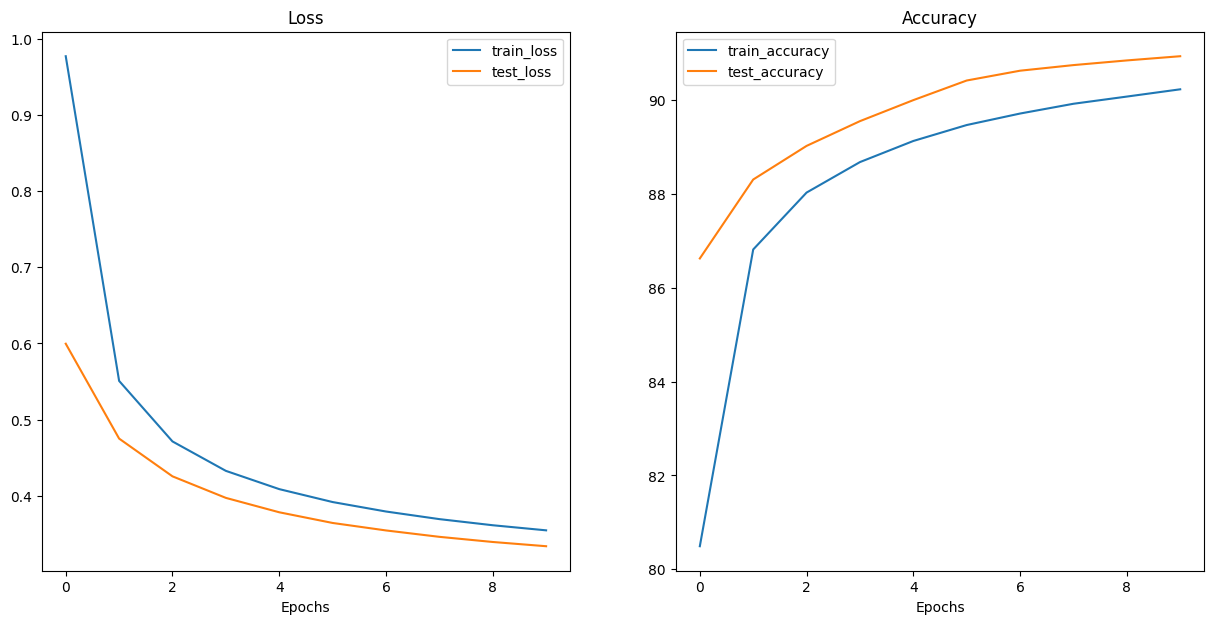

In [16]:
# We should always plot the loss curves!! (And some other metric can also be plotted to inspect performance)
plot_loss_curves(results)

Now, let's look at model that is slightly more complex than the linear model we made. We will introduce the power of non-linearity. This allows the model to find patterns in the data that are non-linear, which is not something that our baseline model can do. 

In [22]:
class FFN(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.layer1 = nn.Linear(28*28, hidden_units)
        self.layer2 = nn.Linear(hidden_units, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.reshape((-1, 28*28))
        return self.layer2(self.relu(self.layer1(x)))

In [23]:
ffn = FFN(hidden_units=128)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=ffn.parameters(), lr=0.01)

results_ffn = train(model=ffn,
                    train_dataloader=train_loader,
                    test_dataloader=test_loader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=EPOCHS)


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.23919 | Train accuracy: 74.85%


 10%|█         | 1/10 [00:19<02:55, 19.49s/it]

Test loss: 0.58579 | Test accuracy: 86.68%
Epoch: 1 | train_loss: 1.2392 | train_acc: 74.8484 | test_loss: 0.5858 | test_acc: 86.6839
Train loss: 0.49438 | Train accuracy: 87.52%


 20%|██        | 2/10 [00:38<02:32, 19.05s/it]

Test loss: 0.40459 | Test accuracy: 89.38%
Epoch: 2 | train_loss: 0.4944 | train_acc: 87.5250 | test_loss: 0.4046 | test_acc: 89.3810
Train loss: 0.39378 | Train accuracy: 89.26%


 30%|███       | 3/10 [00:56<02:09, 18.49s/it]

Test loss: 0.34949 | Test accuracy: 90.39%
Epoch: 3 | train_loss: 0.3938 | train_acc: 89.2557 | test_loss: 0.3495 | test_acc: 90.3861
Train loss: 0.35361 | Train accuracy: 90.10%


 40%|████      | 4/10 [01:14<01:50, 18.47s/it]

Test loss: 0.32220 | Test accuracy: 90.82%
Epoch: 4 | train_loss: 0.3536 | train_acc: 90.1019 | test_loss: 0.3222 | test_acc: 90.8240
Train loss: 0.32925 | Train accuracy: 90.64%


 50%|█████     | 5/10 [01:32<01:31, 18.36s/it]

Test loss: 0.30484 | Test accuracy: 91.40%
Epoch: 5 | train_loss: 0.3293 | train_acc: 90.6433 | test_loss: 0.3048 | test_acc: 91.4013
Train loss: 0.31208 | Train accuracy: 91.17%


 60%|██████    | 6/10 [01:50<01:13, 18.30s/it]

Test loss: 0.29082 | Test accuracy: 91.85%
Epoch: 6 | train_loss: 0.3121 | train_acc: 91.1714 | test_loss: 0.2908 | test_acc: 91.8491
Train loss: 0.29749 | Train accuracy: 91.55%


 70%|███████   | 7/10 [02:10<00:56, 18.78s/it]

Test loss: 0.27862 | Test accuracy: 92.15%
Epoch: 7 | train_loss: 0.2975 | train_acc: 91.5462 | test_loss: 0.2786 | test_acc: 92.1477
Train loss: 0.28534 | Train accuracy: 91.91%


 80%|████████  | 8/10 [02:28<00:36, 18.36s/it]

Test loss: 0.27090 | Test accuracy: 92.36%
Epoch: 8 | train_loss: 0.2853 | train_acc: 91.9143 | test_loss: 0.2709 | test_acc: 92.3567
Train loss: 0.27415 | Train accuracy: 92.22%


 90%|█████████ | 9/10 [02:46<00:18, 18.39s/it]

Test loss: 0.26089 | Test accuracy: 92.71%
Epoch: 9 | train_loss: 0.2741 | train_acc: 92.2208 | test_loss: 0.2609 | test_acc: 92.7150
Train loss: 0.26380 | Train accuracy: 92.50%


100%|██████████| 10/10 [03:05<00:00, 18.52s/it]

Test loss: 0.25175 | Test accuracy: 92.83%
Epoch: 10 | train_loss: 0.2638 | train_acc: 92.4957 | test_loss: 0.2517 | test_acc: 92.8344


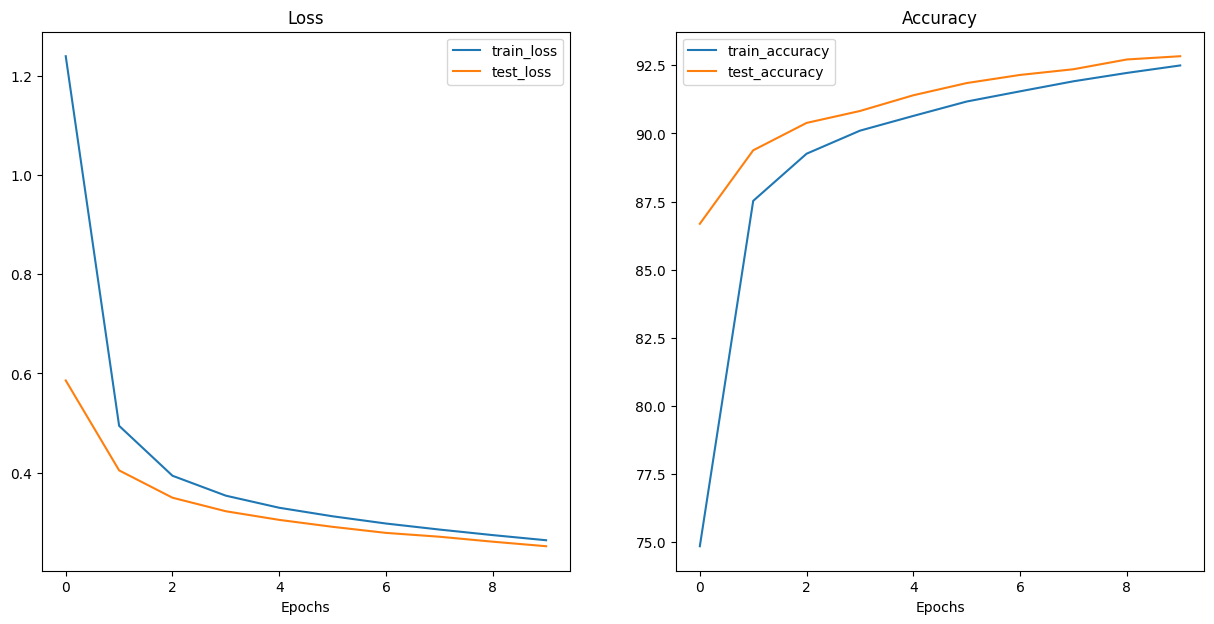

In [24]:
plot_loss_curves(results_ffn)

We can see that by simply introducing one hidden layer and a non-linear activation function (in this case ReLU), our model does quite a lot better already. 

I hope that this tutorial gives a brief overview of how to approach a machine learning problem in Pytorch. My main priority was to create a smooth training pipeline. As you can see it is now very easy to create other models and compare them with others. In the following (intermediate) tutorial, I will focus on extending the pipeline to involve proper cross-validation, experiment with more complex models, and store the results of our model in a neat way using Tensorboard.